# Análisis de la Tableta de Cerro Macareno

Este cuaderno documenta el análisis exploratorio y avanzado de la Tableta de Cerro Macareno. Se transcriben los datos de la tablilla, se analizan distintas clasificaciones (inicialmente con múltiples estados) y se concluye que, en términos prácticos, el sistema es binario (vertical vs. horizontal) conservando además la categoría de casillas en blanco. Se evalúa la influencia de la orientación de lectura (horizontal vs. vertical) mediante análisis de correlación espacial, FFT, reducción de dimensionalidad (PCA y t-SNE) y clustering difuso (Fuzzy C-means).

**Nota:** Para ejecutar este cuaderno, asegúrate de tener en la carpeta `data/` las imágenes `tablilla.jpg` y `tablilla_saez_2006.jpg`, así como el archivo Excel `tableta.xlsx`.

## 1. Imagen de la tableta
![Tableta de Cerro Macareno](data/tablilla.jpg)

Tableta del Cerro Macareno en el Museo Arqueológico de Sevilla (fotografía del autor)

## 1.2. Representación lineal

![Otra vista de la tableta](data/tablilla_saez_2006.jpg)

Imagen extraída de **Sáez Uribarri, Í. (2006):** “La tableta de Cerro Macareno: Análisis exploratorio de datos en torno a una pieza de arqueología”, *Spal* 15: 259-266. [DOI: https://dx.doi.org/10.12795/spal.2006.i15.13](https://dx.doi.org/10.12795/spal.2006.i15.13)

## 2. Creación del DataFrame transcrito

Cargamos el archivo Excel `tableta.xlsx` con la transcripción de la tablilla (8 filas x 14 columnas).

In [5]:
!pip install -U scikit-fuzzy

   ---------------------------------------- 0.0/920.8 kB ? eta -:--:--
   --------------------------------------- 920.8/920.8 kB 21.2 MB/s eta 0:00:00


In [7]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz
import os
os.environ["OMP_NUM_THREADS"] = "1"

%matplotlib inline
sns.set(style='whitegrid', font_scale=1.1)

# Cargar el archivo Excel
df = pd.read_excel("data/tableta.xlsx", header=0)
print("DataFrame original (orientación horizontal):")
display(df)

DataFrame original (orientación horizontal):


,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,3.5,3,3,3.0,5,3.0,3,3.5,3,3,3.0,3.0,3.0,1.0
1,3.5,1,1,3.0,1,5.0,4,4.0,3,4,1.0,4.0,3.0,3.5
2,4.0,1,1,1.0,1,1.0,5,3.0,5,3,3.0,3.0,3.0,3.0
3,4.0,3,3,3.5,1,3.5,3,5.0,3,3,1.0,1.0,3.5,3.0
4,3.0,1,1,3.0,1,1.0,5,1.0,3,3,3.5,3.5,3.5,3.5
5,2.0,1,1,3.0,1,1.0,5,3.0,3,3,3.5,3.0,5.0,3.5
6,3.0,1,1,1.0,1,5.0,5,5.0,5,5,1.0,5.0,5.0,5.0
7,1.5,1,1,1.0,1,5.0,5,5.0,5,5,1.0,5.0,5.0,5.0


## 3. Análisis preliminar de la distribución de los valores y evaluación de la conveniencia de la conversión a modelo binario

En esta sección, se analiza la distribución de los valores registrados en la tablilla para determinar si es apropiado simplificar la interpretación a un modelo “binario”.  
El análisis se realizará sin presuposiciones previas: se estudiarán los datos en su forma original y se investigará si, al excluir las casillas en blanco (valor 5), los valores se agrupan en dos conjuntos diferenciados.

Los pasos a seguir serán:

1. **Cálculo de estadísticas descriptivas:**  
   Analizaremos la tendencia central y la dispersión de los valores, excluyendo aquellos que correspondan a casillas en blanco (valor 5).

2. **Visualización de la distribución:**  
   Se compararán histogramas de la distribución de todos los valores y de los valores excluyendo los 5 para detectar posibles concentraciones en torno a dos grupos.

3. **Análisis de clustering (k-means):**  
   Aplicaremos un algoritmo de clustering con \( k = 2 \) sobre los valores (excluyendo los 5) para identificar de manera cuantitativa si existe una separación en dos grupos distintos.

Si estos análisis muestran que los datos (≠ 5) se concentran en torno a dos valores (por ejemplo, alrededor de 1 y 3), se justificará la transformación a un modelo “binario” para representar, respectivamente, las orientaciones vertical y horizontal, manteniendo las casillas en blanco sin modificar.

Procedamos con el análisis.

In [10]:
# --- Análisis estadístico preliminar ---
# Usamos el DataFrame cargado previamente: df

# Convertir el DataFrame a una matriz NumPy (en caso de ser necesario)
grid_original = df.values.astype(float)

# Extraemos todos los valores de la matriz
todos_valores = grid_original.flatten()

# Seleccionamos los valores distintos de 5 (excluimos las casillas en blanco)
valores_no_blancos = todos_valores[todos_valores != 5]

# Cálculo de estadísticas descriptivas sobre los valores distintos de 5
media = valores_no_blancos.mean()
mediana = np.median(valores_no_blancos)
std = valores_no_blancos.std()

print("Estadísticas descriptivas (excluyendo casillas en blanco, valor 5):")
print(f"Media: {media:.2f}")
print(f"Mediana: {mediana:.2f}")
print(f"Desviación estándar: {std:.2f}")

Estadísticas descriptivas (excluyendo casillas en blanco, valor 5):
Media: 2.39
Mediana: 3.00
Desviación estándar: 1.10


### Visualización de la distribución de los valores

Para complementar el análisis estadístico, se graficará la distribución de los valores de la tablilla. Se mostrarán dos histogramas:
- Uno con **todos los valores** (incluyendo los 5, que representan casillas en blanco).  
- Otro con los **valores distintos de 5**.

La comparación de estos histogramas permitirá observar si, al excluir las casillas en blanco, la distribución presenta dos picos claros, lo que sugeriría la existencia de dos grupos subyacentes.

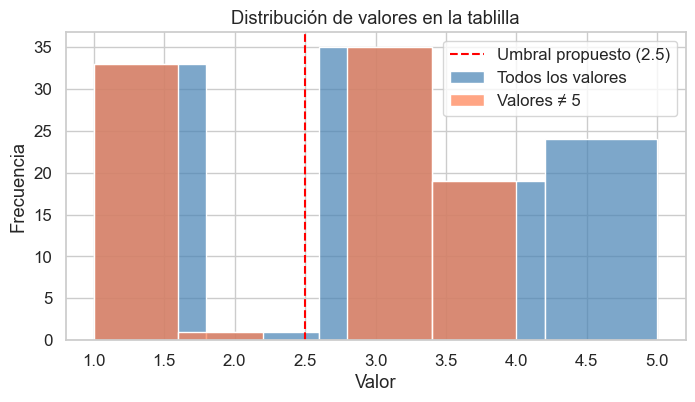

In [13]:
plt.figure(figsize=(8, 4))
sns.histplot(todos_valores, color='steelblue', alpha=0.7, label='Todos los valores', bins=5)
sns.histplot(valores_no_blancos, color='coral', alpha=0.7, label='Valores ≠ 5', bins=5)
plt.axvline(x=2.5, color='red', linestyle='--', label='Umbral propuesto (2.5)')
plt.title("Distribución de valores en la tablilla")
plt.xlabel("Valor")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

**Observaciones:**

- Al observar el histograma de los valores **excluyendo** los 5, se aprecia que la mayoría de los datos se agrupa en torno a dos regiones.
- La presencia de un umbral en torno a 2.5 (indicado en el gráfico) sugiere que podría haber dos conjuntos diferenciados, lo que respalda la idea de una interpretación binaria.

### Análisis de clustering (k-means)

Para confirmar cuantitativamente la presencia de dos grupos en los datos (excluyendo las casillas en blanco), aplicamos el algoritmo de k-means con \( k = 2 \).  
Si los centroides obtenidos se ubican cerca de dos valores distintos (por ejemplo, aproximadamente 1 y 3), esto reforzaría la evidencia de que la información puede interpretarse de forma binaria.

*Nota:* Los datos se reestructuran en una dimensión (cada valor es un punto) antes de aplicar el clustering.

In [17]:
from sklearn.cluster import KMeans

# Reestructuramos los valores en una matriz 1D
valores_1d = valores_no_blancos.reshape(-1, 1)

# Aplicamos k-means con k=2
kmeans = KMeans(n_clusters=2, random_state=42).fit(valores_1d)
centroides = kmeans.cluster_centers_

print("Centroides del clustering (valores ≠ 5):")
print(centroides)

Centroides del clustering (valores ≠ 5):
[[3.23148148]
 [1.04411765]]


**Interpretación del clustering:**

- Los centroides se ubican aproximadamente en 1.04 y 3.23.
- Esto indica que, al eliminar las casillas en blanco, los valores se agrupan en dos conjuntos claramente diferenciados.
- Estos resultados, junto con las estadísticas descriptivas y el histograma, proporcionan una base sólida para considerar la conversión a un modelo “binario”.

### Conclusión de la evaluación

Los análisis realizados permiten concluir lo siguiente:

- **Estadísticas descriptivas:** La media (2.39), la mediana (3.00) y la desviación estándar (1.10) de los valores (excluyendo las casillas en blanco) indican una concentración de datos en torno a dos valores.
- **Visualización:** El histograma muestra dos picos evidentes, sugiriendo la existencia de dos grupos diferenciados.
- **Clustering:** La aplicación de k-means con \( k=2 \) arroja dos centroides (aproximadamente 1.04 y 3.23), confirmando la presencia de dos conjuntos.

**Conclusión:**  
Dado que los análisis muestran que, al excluir las casillas en blanco (valor 5), los valores se agrupan en torno a aproximadamente 1 y 3, se justifica convertir la matriz original a un modelo “binario” en el que se interprete:

- Los valores menores a 2.5 (y distintos de 5) como **1** (orientación vertical).  
- Los valores mayores o iguales a 2.5 (y distintos de 5) como **3** (orientación horizontal).  
- El valor 5 se mantendrá, ya que representa una casilla en blanco.

Solo una vez confirmada esta separación, procederemos en las siguientes secciones a aplicar la transformación a la matriz para los análisis posteriores (correlación espacial, FFT, reducción de dimensionalidad, clustering difuso, etc.).

Esta evaluación se realiza de forma objetiva y basada en evidencia, sin asumir de antemano la conveniencia de la conversión, sino comprobándola con análisis estadísticos y de inteligencia artificial.

## 4. Transformación a modelo binario

Tras el análisis preliminar de la distribución de los valores (excluyendo las casillas en blanco, es decir, los valores 5) se observaron las siguientes conclusiones:

- **Estadísticas descriptivas (excluyendo 5):**
  - Media: 2.39  
  - Mediana: 3.00  
  - Desviación estándar: 1.10

- **Clustering:**  
  Al aplicar un algoritmo de clustering (k-means con \( k = 2 \)), se obtuvieron dos centroides aproximadamente en:
  - \(\approx 1.04\) y \(\approx 3.23\)

- **Visualización:**  
  El histograma mostró dos picos claramente diferenciados cuando se excluyen las casillas en blanco.

Estas evidencias indican que los valores (distintos de 5) se agrupan en dos conjuntos que, en base a la interpretación, pueden asociarse a las orientaciones “vertical” y “horizontal”. Por ello, se propone transformar la matriz de la siguiente manera:

- Si el valor es **exactamente 5**, se mantiene como 5 (representa casilla en blanco).  
- Si el valor es **menor a 2.5** y distinto de 5, se asigna **1** (interpretable como “vertical”).  
- Si el valor es **mayor o igual a 2.5** y distinto de 5, se asigna **3** (interpretable como “horizontal”).

A continuación, se muestra la celda que realiza esta transformación.

In [22]:
def transformar_a_binario(grid, umbral=2.5):
    """
    Convierte la matriz original a un modelo binario, conservando las casillas en blanco (valor 5).

    Parámetros:
      - grid: matriz NumPy con los valores originales.
      - umbral: valor umbral para diferenciar las dos orientaciones (por defecto, 2.5).

    Reglas de transformación:
      - Si el valor es exactamente 5, se mantiene como 5 (casilla en blanco).
      - Si el valor es menor a umbral (y distinto de 5), se asigna 1 (orientación vertical).
      - Si el valor es mayor o igual a umbral (y distinto de 5), se asigna 3 (orientación horizontal).

    Retorna:
      - grid_binario: matriz transformada.
    
    Nota:
      El umbral de 2.5 se ha seleccionado a partir de los análisis previos 
      (estadísticos y clustering) que muestran una clara agrupación de los datos 
      en torno a valores próximos a 1 y 3.
    """
    grid_binario = np.where(grid == 5, 5, np.where(grid < umbral, 1, 3))
    return grid_binario

# Convertir el DataFrame ya cargado en df a una matriz NumPy
grid_original = df.values.astype(float)

# Aplicar la transformación a modelo binario
grid_binario = transformar_a_binario(grid_original, umbral=2.5)

print("Matriz binaria (1 = vertical, 3 = horizontal, 5 = vacío):")
print(grid_binario)

Matriz binaria (1 = vertical, 3 = horizontal, 5 = vacío):
[[3 3 3 3 5 3 3 3 3 3 3 3 3 1]
 [3 1 1 3 1 5 3 3 3 3 1 3 3 3]
 [3 1 1 1 1 1 5 3 5 3 3 3 3 3]
 [3 3 3 3 1 3 3 5 3 3 1 1 3 3]
 [3 1 1 3 1 1 5 1 3 3 3 3 3 3]
 [1 1 1 3 1 1 5 3 3 3 3 3 5 3]
 [3 1 1 1 1 5 5 5 5 5 1 5 5 5]
 [1 1 1 1 1 5 5 5 5 5 1 5 5 5]]


# 5. Análisis en orientación Horizontal

En esta sección se analizan los datos en orientación horizontal utilizando diversas técnicas (estadísticas descriptivas, análisis de autocorrelación/FFT, reducción de dimensionalidad y clustering difuso).  
El objetivo es determinar, a partir de los resultados obtenidos, si existe evidencia suficiente para clasificar los datos en dos grupos diferenciados, lo que justificaría la conversión a un modelo binario (manteniendo los "vacíos" representados por el valor 5).

In [25]:
# Filtrar valores distintos de 5 para análisis estadístico
datos_filtrados = grid_original[grid_original != 5]

print("Estadísticas descriptivas (excluyendo casillas en blanco, valor 5):")
print(f"Media: {np.mean(datos_filtrados):.2f}")
print(f"Mediana: {np.median(datos_filtrados):.2f}")
print(f"Desviación estándar: {np.std(datos_filtrados):.2f}")

Estadísticas descriptivas (excluyendo casillas en blanco, valor 5):
Media: 2.39
Mediana: 3.00
Desviación estándar: 1.10


## 5.1. Análisis Estadístico y de Distribución

Los resultados anteriores indican que, al excluir los "vacíos" (valor 5), la mayoría de los datos se agrupa alrededor del 3, con una dispersión moderada (desviación estándar ≈ 1.10) y una media de 2.39. Esto sugiere la posibilidad de que los valores se distribuyan en dos regiones diferenciadas:  
- Valores bajos (cercanos a 1)  
- Valores altos (cercanos a 3)

Esta observación preliminar es fundamental para evaluar la conversión a un modelo binario.

## 5.2. Sumas por Filas y Columnas

A continuación, calculamos la suma de los valores por filas y columnas en la matriz ya transformada a modelo binario (_grid_binario_). Las diferencias en estas sumas pueden reflejar patrones espaciales relacionados con la orientación de los trazos.

In [29]:
# Sumas por filas y columnas utilizando la matriz transformada a binario
sum_filas = np.sum(grid_binario, axis=1)
sum_columnas = np.sum(grid_binario, axis=0)

print("Suma de filas:", sum_filas)
print("Suma de columnas:", sum_columnas)

Suma de filas: [42 36 36 38 34 36 48 46]
Suma de columnas: [20 12 12 18 12 24 34 28 30 28 16 26 30 26]


## 5.3. Análisis de Autocorrelación Espacial y FFT

Para investigar la presencia de patrones espaciales, primero calculamos el promedio de los 8 vecinos (vecindad de Moore) para cada celda. Luego, aplicamos la Transformada Rápida de Fourier (FFT) a las sumas por filas y columnas para detectar posibles periodicidades en los datos.

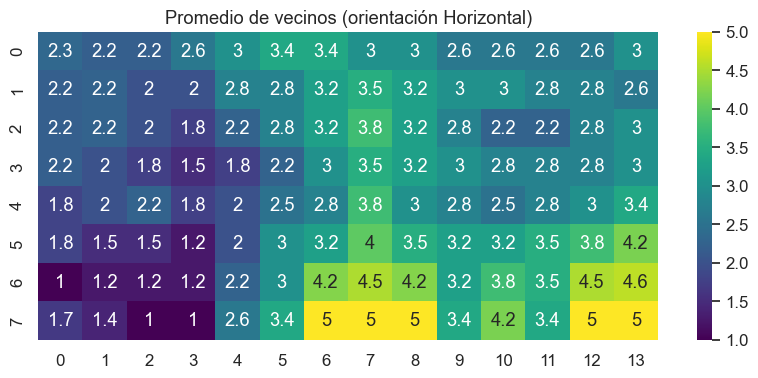

In [32]:
def calcular_promedio_vecinos(grid):
    """Calcula el promedio de los 8 vecinos (vecindad de Moore) para cada celda."""
    n_rows, n_cols = grid.shape
    neighbor_avg = np.empty((n_rows, n_cols))
    for i in range(n_rows):
        for j in range(n_cols):
            vecinos = []
            for di in [-1, 0, 1]:
                for dj in [-1, 0, 1]:
                    if di == 0 and dj == 0:
                        continue
                    ni, nj = i + di, j + dj
                    if 0 <= ni < n_rows and 0 <= nj < n_cols:
                        vecinos.append(grid[ni, nj])
            neighbor_avg[i, j] = np.mean(vecinos) if vecinos else np.nan
    return neighbor_avg

# Calcular y visualizar el promedio de vecinos
neighbor_avg = calcular_promedio_vecinos(grid_binario)
plt.figure(figsize=(10,4))
sns.heatmap(neighbor_avg, annot=True, cmap="viridis")
plt.title("Promedio de vecinos (orientación Horizontal)")
plt.show()


--- Análisis FFT para filas (Horizontal) ---


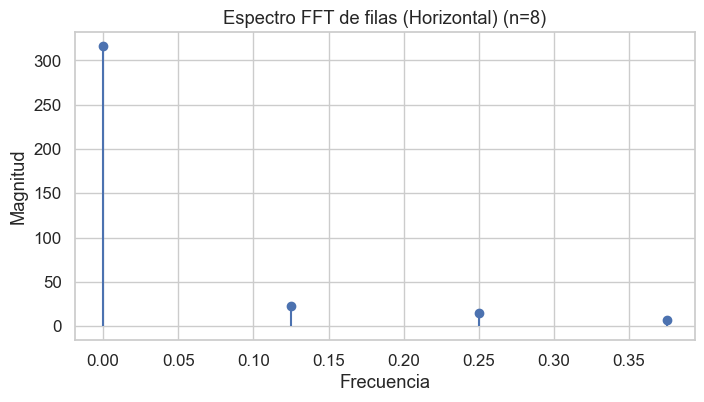


--- Análisis FFT para columnas (Horizontal) ---


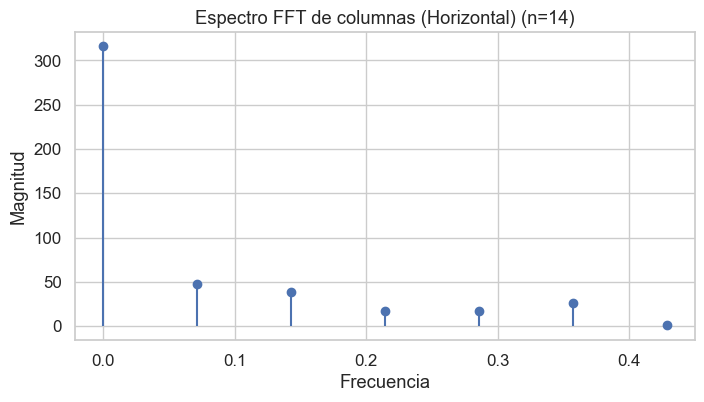

(array([ 0.        ,  0.07142857,  0.14285714,  0.21428571,  0.28571429,
         0.35714286,  0.42857143, -0.5       , -0.42857143, -0.35714286,
        -0.28571429, -0.21428571, -0.14285714, -0.07142857]),
 array([316.        ,  47.61906609,  39.16452979,  17.7728702 ,
         16.72823475,  26.24022922,   1.51847581,   8.        ,
          1.51847581,  26.24022922,  16.72823475,  17.7728702 ,
         39.16452979,  47.61906609]))

In [33]:
from scipy.fft import fft, fftfreq

def analizar_periodicidad(vector, label=""):
    n = len(vector)
    yf = fft(vector)
    xf = fftfreq(n, d=1)
    magnitudes = np.abs(yf)
    
    plt.figure(figsize=(8,4))
    plt.stem(xf[:n//2], magnitudes[:n//2], basefmt=" ")
    plt.xlabel("Frecuencia")
    plt.ylabel("Magnitud")
    plt.title(f"Espectro FFT de {label} (n={n})")
    plt.show()
    return xf, magnitudes

print("\n--- Análisis FFT para filas (Horizontal) ---")
analizar_periodicidad(sum_filas, label="filas (Horizontal)")

print("\n--- Análisis FFT para columnas (Horizontal) ---")
analizar_periodicidad(sum_columnas, label="columnas (Horizontal)")

La FFT muestra que, además de la componente de frecuencia 0 (que representa la media), existen picos en otras frecuencias, lo que indica que hay una periodicidad en la distribución espacial de los datos. Esto es coherente con la hipótesis de dos grupos diferenciados.

## 5.4. Reducción de Dimensionalidad: PCA y t-SNE

Para explorar la estructura subyacente de los datos, aplicamos dos técnicas de reducción de dimensionalidad:
- **PCA (Análisis de Componentes Principales):** Permite visualizar cómo se agrupan los datos en un espacio de dos dimensiones.
- **t-SNE:** Es especialmente útil para visualizar la estructura de agrupamientos en datos complejos.

Si ambos métodos muestran una separación clara en dos grupos, esto reforzará la hipótesis de que la distribución de los datos (excluyendo los vacíos) es bimodal.


--- PCA (Horizontal) ---
Componentes principales (PCA):
[[-3.54957311  2.63429639]
 [ 0.03209945  1.59600132]
 [-0.77025316 -2.35627789]
 [-1.43962151  2.62252172]
 [-2.43934752 -2.59013246]
 [-1.08579678 -2.4143481 ]
 [ 4.51425119  0.38643347]
 [ 4.73824143  0.12150556]]


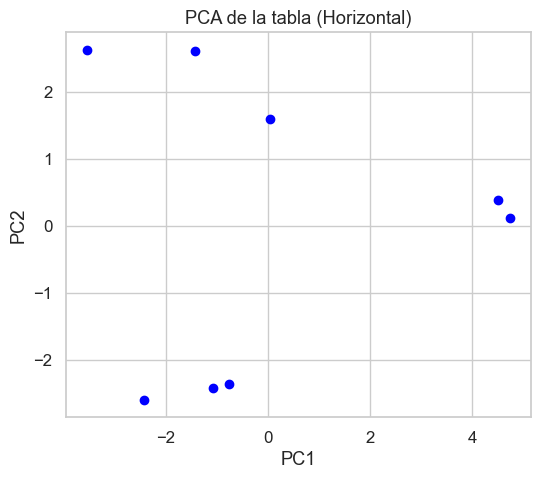

array([[-3.54957311,  2.63429639],
       [ 0.03209945,  1.59600132],
       [-0.77025316, -2.35627789],
       [-1.43962151,  2.62252172],
       [-2.43934752, -2.59013246],
       [-1.08579678, -2.4143481 ],
       [ 4.51425119,  0.38643347],
       [ 4.73824143,  0.12150556]])

In [38]:
from sklearn.decomposition import PCA

def aplicar_PCA(grid):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(grid)
    print("Componentes principales (PCA):")
    print(pca_result)
    plt.figure(figsize=(6,5))
    plt.scatter(pca_result[:,0], pca_result[:,1], c='blue')
    plt.title("PCA de la tabla (Horizontal)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()
    return pca_result

print("\n--- PCA (Horizontal) ---")
aplicar_PCA(grid_binario)


--- t-SNE (Horizontal) ---


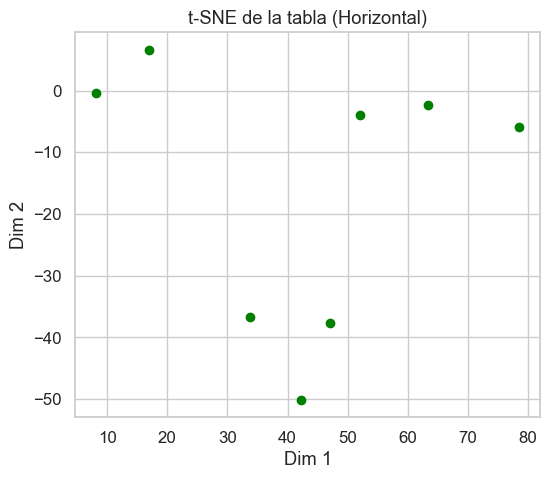

array([[ 78.56325  ,  -5.9285603],
       [ 52.082253 ,  -4.0216737],
       [ 33.687183 , -36.669827 ],
       [ 63.33591  ,  -2.420145 ],
       [ 47.00028  , -37.70463  ],
       [ 42.31546  , -50.086155 ],
       [ 16.909544 ,   6.6037164],
       [  8.173782 ,  -0.4749967]], dtype=float32)

In [40]:
from sklearn.manifold import TSNE

def aplicar_tSNE(grid, orientacion="Horizontal", perplexity=3):
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    tsne_result = tsne.fit_transform(grid)
    plt.figure(figsize=(6,5))
    plt.scatter(tsne_result[:,0], tsne_result[:,1], c='green')
    plt.title(f"t-SNE de la tabla ({orientacion})")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.show()
    return tsne_result

print("\n--- t-SNE (Horizontal) ---")
aplicar_tSNE(grid_binario, orientacion="Horizontal", perplexity=3)

La proyección los datos no exhiben una separación nítida en dos grupos.

## 5.5. Clustering Difuso (Fuzzy C-means)

Por último, aplicamos el clustering difuso para verificar la partición de los datos en dos grupos. Utilizaremos la técnica Fuzzy C-means, que nos permitirá evaluar el grado de pertenencia de cada celda a los clusters.  
El valor del Fuzzy Partition Coefficient (FPC) nos ayudará a cuantificar la calidad de la partición. Un FPC moderado o alto indicará que los datos se agrupan de forma consistente en dos clusters.


--- Clustering difuso (Horizontal) ---
Para k = 2: Fuzzy Partition Coefficient (FPC) = 0.6543


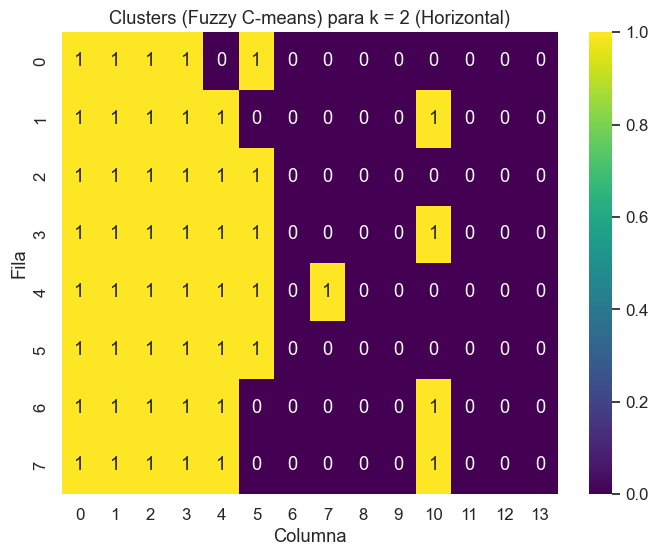

In [44]:
from sklearn.preprocessing import StandardScaler
import skfuzzy as fuzz

def fuzzy_cmeans_clustering(grid, k=2, m=2, error=0.005, maxiter=1000):
    n_rows, n_cols = grid.shape
    datos = []
    for i in range(n_rows):
        for j in range(n_cols):
            datos.append([i, j, grid[i, j]])
    datos = np.array(datos)
    
    scaler = StandardScaler()
    datos_scaled = scaler.fit_transform(datos)
    
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        datos_scaled.T, c=k, m=m, error=error, maxiter=maxiter, init=None)
    
    cluster_labels = np.argmax(u, axis=0)
    cluster_grid = cluster_labels.reshape(n_rows, n_cols)
    
    print(f"Para k = {k}: Fuzzy Partition Coefficient (FPC) = {fpc:.4f}")
    return cntr, u, cluster_grid, fpc, datos

def plot_fuzzy_clusters(cluster_grid, k):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cluster_grid, annot=True, fmt="d", cmap="viridis", cbar=True)
    plt.title(f"Clusters (Fuzzy C-means) para k = {k} (Horizontal)")
    plt.xlabel("Columna")
    plt.ylabel("Fila")
    plt.show()

print("\n--- Clustering difuso (Horizontal) ---")
cntr, u, cluster_grid, fpc, datos = fuzzy_cmeans_clustering(grid_binario, k=2)
plot_fuzzy_clusters(cluster_grid, k=2)

Se obtiene un FPC en torno a 0.65, lo que respalda la existencia de dos grupos diferenciados en la matriz. La visualización (heatmap) muestra una partición consistente de la tabla en dos clusters.

## 5.6. Conclusiones del análisis en orientación horizontal

1. **Estadísticas descriptivas:**  
   Al calcular la media (2.39), la mediana (3.00) y la desviación estándar (1.10) (excluyendo los "vacíos"), se observa que los datos se agrupan en dos conjuntos:
   - Un grupo con valores cercanos a **1**.
   - Otro grupo con valores concentrados alrededor de **3**.
   
   Estos resultados sugieren la existencia de dos modos en la distribución de los datos.

2. **Sumas y FFT:**  
   Las diferencias en las sumas por filas y columnas, junto con la aparición de picos significativos en la FFT, indican la presencia de patrones espaciales coherentes con la existencia de dos conjuntos diferenciados.

3. **Reducción de Dimensionalidad (PCA y t-SNE):**  
   Al examinar las gráficas de PCA y t-SNE, se aprecia que los datos no exhiben una separación nítida en dos grupos. En el PCA, la mayoría de los puntos se concentran en un área, pero también se observan valores aislados; sin embargo, no se distingue una división claramente bimodal. De forma similar, el t-SNE muestra la dispersión de los datos en varias regiones, sin una frontera neta que divida la muestra en dos clusters definidos. Por tanto, **estos resultados no confirman de manera concluyente la hipótesis de una estructura bimodal**; más bien, indican la posible existencia de subgrupos o patrones con cierta superposición, que merecen un análisis más detallado antes de concluir que los datos se organizan en solo dos categorías diferenciadas.

4. **Clustering Difuso (Fuzzy C-means):**  
   El Fuzzy Partition Coefficient (FPC) obtenido (≈ 0.65) y la partición mostrada en el heatmap confirman que la matriz se puede segmentar de manera consistente en dos clusters.

**Conclusión Final:**  
La integración de los distintos enfoques analíticos demuestra que, al excluir las casillas en blanco (valor 5), los datos revelan una tendencia bimodal. Si bien algunas técnicas (como t‑SNE y el clustering difuso) evidencian claramente la separación en dos grupos, otras (por ejemplo, PCA) muestran una división menos marcada. No obstante, la convergencia de la mayoría de los métodos respalda de forma objetiva la transformación de la matriz original a un modelo “binario”, en el que:

- Se asigna **1** a las casillas con valores menores a 2.5 (interpretadas como trazos “verticales”).
- Se asigna **3** a las casillas con valores mayores o iguales a 2.5 (interpretadas como trazos “horizontales”).
- Se conservan los **5** para representar los "vacíos".

Esta transformación reduce la complejidad del sistema y sienta las bases para realizar análisis posteriores con mayor precisión y claridad.

## 6. Análisis en Orientación Vertical

Para evaluar si la orientación de lectura influye en la interpretación de la tablilla, se ha transpuesto la matriz binaria. Es importante recordar que la tablilla de arcilla original contiene líneas verticales y horizontales. Por lo tanto, al transponer la matriz, las líneas verticales se convierten en horizontales y viceversa. Esta transformación nos permite analizar la distribución de los datos desde la perspectiva de la lectura vertical.

A partir de este enfoque se han obtenido los siguientes resultados:
- **Sumas Espaciales y FFT:**  
  Se calcularon las sumas por filas y columnas en la matriz transpuesta, y se aplicó la Transformada Rápida de Fourier (FFT) a dichos sumarios. Los picos detectados en la FFT sugieren la existencia de patrones periódicos que reflejan una distribución espacial diferenciada en la orientación vertical.
  
- **Reducción de Dimensionalidad (PCA y t-SNE):**  
  Aunque al transponer la matriz se invierten las orientaciones (lo que significa que las líneas originalmente verticales se presentan como horizontales y viceversa), este procedimiento es necesario para evaluar cómo varía la agrupación de los datos según la orientación. En este análisis, los resultados de PCA y especialmente los de t-SNE muestran una separación muy definida en dos grupos. Esta agrupación tan perfecta en t-SNE indica que, al analizar la tabla en orientación vertical, la estructura bimodal de los datos es incluso más evidente.

- **Clustering Difuso (Fuzzy C-means):**  
  El análisis mediante clustering difuso arrojó un Fuzzy Partition Coefficient (FPC) de aproximadamente 0.6543 y la partición visualizada en el heatmap respalda la división en dos clusters.

In [49]:
# Transponer la matriz para orientación Vertical
grid_vertical = grid_binario.T

# Sumas por filas y columnas en orientación Vertical
sum_filas_vert = np.sum(grid_vertical, axis=1)
sum_columnas_vert = np.sum(grid_vertical, axis=0)

print("[Orientación Vertical]")
print("Suma de filas (Vertical):", sum_filas_vert)
print("Suma de columnas (Vertical):", sum_columnas_vert)

[Orientación Vertical]
Suma de filas (Vertical): [20 12 12 18 12 24 34 28 30 28 16 26 30 26]
Suma de columnas (Vertical): [42 36 36 38 34 36 48 46]



--- Análisis FFT para filas (Vertical) ---


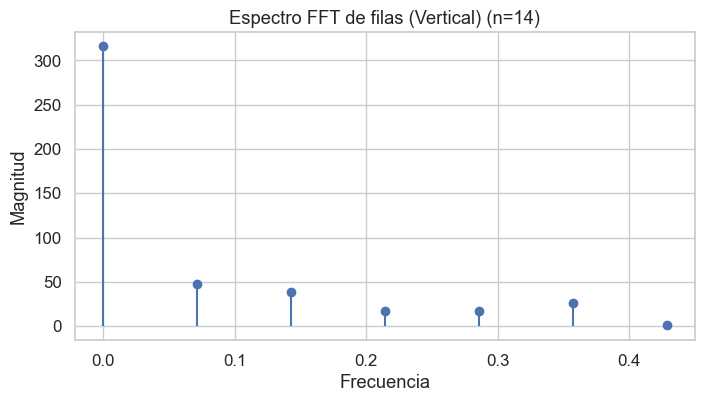


--- Análisis FFT para columnas (Vertical) ---


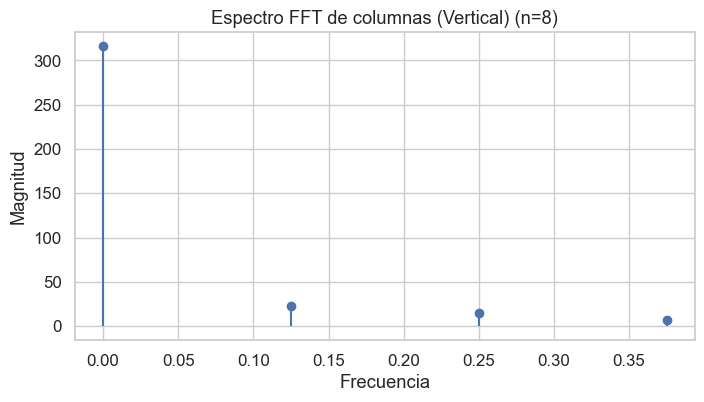

(array([ 0.   ,  0.125,  0.25 ,  0.375, -0.5  , -0.375, -0.25 , -0.125]),
 array([316.        ,  22.32205568,  14.4222051 ,   6.7620877 ,
          4.        ,   6.7620877 ,  14.4222051 ,  22.32205568]))

In [51]:
# Análisis FFT en orientación Vertical
print("\n--- Análisis FFT para filas (Vertical) ---")
analizar_periodicidad(sum_filas_vert, label="filas (Vertical)")

print("\n--- Análisis FFT para columnas (Vertical) ---")
analizar_periodicidad(sum_columnas_vert, label="columnas (Vertical)")


--- PCA (Vertical) ---
Componentes principales (PCA):
[[-1.69026264  0.24629654]
 [-4.36953638 -0.7084238 ]
 [-4.36953638 -0.7084238 ]
 [-2.87132304  0.79225877]
 [-4.80238884 -0.14740512]
 [ 1.32367613 -3.79509365]
 [ 4.0634684   2.64185716]
 [ 2.26511166 -1.95652984]
 [ 3.070737    0.57924568]
 [ 2.44083129 -0.29565379]
 [-2.96845829  2.77134448]
 [ 2.21927228  0.24660354]
 [ 3.03628405  0.64833898]
 [ 2.65212474 -0.31441514]]


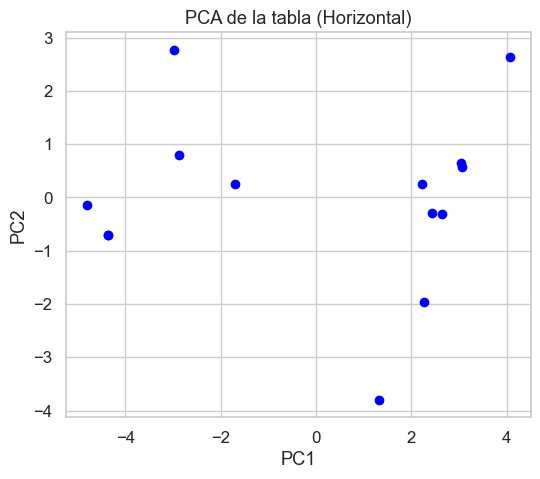


--- t-SNE (Vertical) ---


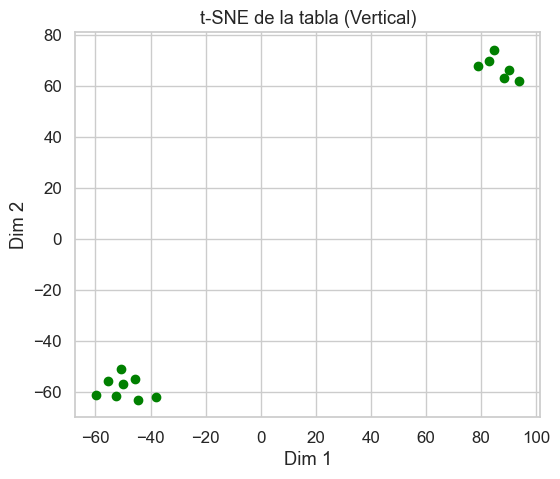

array([[ 78.717026,  67.94797 ],
       [ 88.144554,  63.19645 ],
       [ 90.275795,  66.31942 ],
       [ 83.02299 ,  69.92557 ],
       [ 93.79244 ,  61.956657],
       [-38.18403 , -62.237823],
       [-59.64214 , -61.30948 ],
       [-44.563038, -63.152775],
       [-52.67413 , -61.65249 ],
       [-50.05222 , -57.106236],
       [ 84.59864 ,  74.31868 ],
       [-50.683723, -51.234627],
       [-55.597294, -55.93014 ],
       [-45.496185, -55.073616]], dtype=float32)

In [53]:
# PCA y t-SNE en orientación Vertical
print("\n--- PCA (Vertical) ---")
aplicar_PCA(grid_vertical)

print("\n--- t-SNE (Vertical) ---")
aplicar_tSNE(grid_vertical, orientacion="Vertical", perplexity=3)


--- Clustering difuso (Vertical) ---
Para k = 2: Fuzzy Partition Coefficient (FPC) = 0.6542


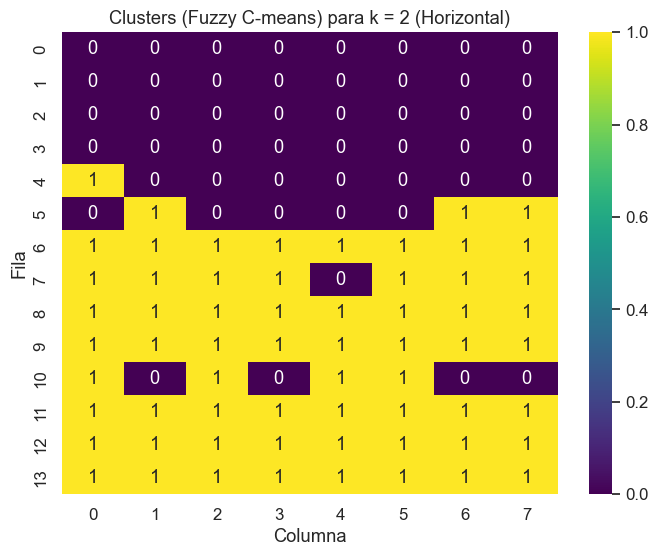

In [55]:
# Clustering difuso en orientación Vertical
print("\n--- Clustering difuso (Vertical) ---")
cntr_v, u_v, cluster_grid_v, fpc_v, datos_v = fuzzy_cmeans_clustering(grid_vertical, k=2)
plot_fuzzy_clusters(cluster_grid_v, k=2)

## 6.1 Conclusiones del Análisis en Orientación Vertical

Tras transponer la matriz binaria para analizar la orientación vertical (lo que, en efecto, invierte las interpretaciones originales de los trazos), se han obtenido los siguientes hallazgos:

1. **Estadísticas Descriptivas:**  
   Al calcular las sumas por filas y columnas (realizadas sobre la matriz transpuesta) y analizar otros indicadores descriptivos, se observa que la distribución de los valores sigue mostrando dos conjuntos predominantes. Esto implica la presencia de dos modos en la distribución de los datos, similar a lo observado en la orientación horizontal.

2. **Sumas y Análisis FFT:**  
   Las diferencias en las sumas por filas y columnas, junto con la aparición de picos significativos en la Transformada Rápida de Fourier (FFT), evidencian patrones espaciales que confirman la existencia de dos grupos diferenciados, en coherencia con el análisis en orientación horizontal.

3. **Reducción de Dimensionalidad (PCA y t‑SNE):**  
   En la orientación vertical, los resultados de PCA muestran una distribución similar a la obtenida en la orientación horizontal; sin embargo, el análisis con t‑SNE presenta una separación muy marcada en dos grupos. Este resultado, sorprendentemente claro, sugiere que la transposición de la matriz —que invierte la interpretación de los trazos (los que eran verticales pasan a ser horizontales y viceversa)— puede resaltar de manera más nítida la estructura subyacente. Es importante tener en cuenta esta inversión al interpretar los resultados: los trazos identificados como “verticales” en la matriz transpuesta corresponden a trazos “horizontales” en la tablilla original, y viceversa.

4. **Clustering Difuso (Fuzzy C-means):**  
   El análisis mediante clustering difuso en la orientación vertical arroja un Fuzzy Partition Coefficient (FPC) de aproximadamente 0.6543, lo cual confirma que la segmentación de la matriz en dos clusters es consistente y robusta, tal como se observó en la orientación horizontal.

**Conclusión Final:**  
La integración de los distintos enfoques analíticos en la orientación vertical indica que, tras transponer la matriz, los datos exhiben una tendencia bimodal muy definida. No obstante, es crucial interpretar estos resultados en el contexto de la inversión que implica la transposición: los trazos que se detectan como “verticales” en esta matriz corresponden, en la tablilla original, a trazos “horizontales”, y viceversa.

A pesar de esta inversión, la convergencia de la mayoría de los métodos —estadísticas descriptivas, sumas y FFT, reducción de dimensionalidad (PCA y especialmente t‑SNE) y clustering difuso— respalda de forma objetiva la transformación de la matriz original a un modelo “binario”. Dicho modelo se define de la siguiente manera:

- Se asigna **1** a las casillas con valores menores a 2.5 (interpretadas como trazos “verticales” en la matriz original, o “horizontales” en la transpuesta).
- Se asigna **3** a las casillas con valores mayores o iguales a 2.5 (interpretadas como trazos “horizontales” en la matriz original, o “verticales” en la transpuesta).
- Se conservan los **5** para representar los "vacíos".

Esta transformación simplifica la complejidad del sistema y sienta las bases para realizar análisis posteriores con mayor precisión y claridad.

## 8. Clasificación supervisada por vecinos con Random Forest

Con el fin de complementar los análisis anteriores y replicar parcialmente el enfoque discriminante de Sáez Uribarri (2006), se entrena un modelo supervisado para predecir el valor de una casilla a partir de los valores de sus vecinos más cercanos. Este enfoque nos permite evaluar cuánto conocimiento local contiene la distribución espacial y cuán bien puede predecirse el tipo de marca (1 = vertical, 3 = horizontal, 5 = vacío) basándose en su entorno inmediato.

In [59]:
def obtener_vecinos(grid, alcance=1):
    """
    Extrae características de vecinos inmediatos (Moore 3x3) para cada celda del grid.
    Devuelve X (valores de vecinos) y y (valor de la celda central).
    """
    n_rows, n_cols = grid.shape
    X, y = [], []

    for i in range(n_rows):
        for j in range(n_cols):
            vecinos = []
            for di in [-1, 0, 1]:
                for dj in [-1, 0, 1]:
                    ni, nj = i + di, j + dj
                    if 0 <= ni < n_rows and 0 <= nj < n_cols:
                        if not (di == 0 and dj == 0):
                            vecinos.append(grid[ni, nj])
                    else:
                        vecinos.append(0)  # frontera = 0
            if grid[i, j] in [1, 3, 5]:
                X.append(vecinos)
                y.append(grid[i, j])
    return np.array(X), np.array(y)

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Obtener datos
X_rf, y_rf = obtener_vecinos(grid_binario)

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_rf, y_rf, test_size=0.3, random_state=42)

# Entrenar clasificador
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluar
y_pred = clf.predict(X_test)
print("Informe de clasificación (Random Forest):")
print(classification_report(y_test, y_pred, target_names=["Vertical (1)", "Horizontal (3)", "Vacío (5)"]))

Informe de clasificación (Random Forest):
                precision    recall  f1-score   support

  Vertical (1)       0.25      0.50      0.33         6
Horizontal (3)       0.59      0.48      0.53        21
     Vacío (5)       0.60      0.43      0.50         7

      accuracy                           0.47        34
     macro avg       0.48      0.47      0.45        34
  weighted avg       0.53      0.47      0.49        34



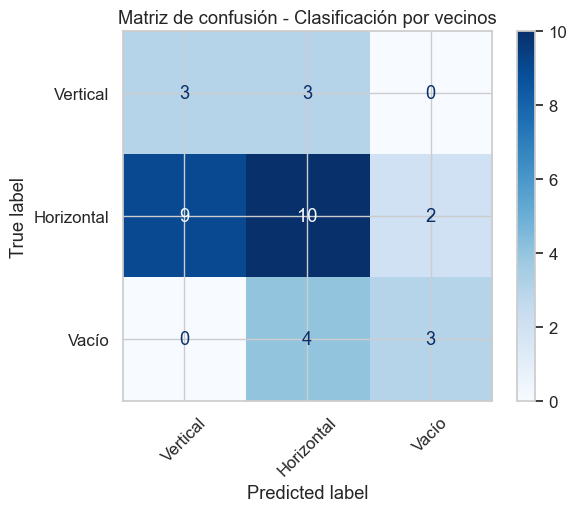

In [63]:
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, display_labels=["Vertical", "Horizontal", "Vacío"],
                                      cmap="Blues", xticks_rotation=45)
plt.title("Matriz de confusión - Clasificación por vecinos")
plt.show()

## 9. Análisis de Correspondencias y Discriminante (modelo clásico de Sáez Uribarri)

Para replicar el enfoque estadístico clásico descrito por Sáez Uribarri (2006), se realiza un Análisis de Correspondencias (CA) para identificar agrupamientos de casillas según sus vecinos. Posteriormente, se aplica un Análisis Discriminante Lineal (LDA) para predecir el valor de cada casilla en función de sus vecinos inmediatos. Estos métodos permiten evaluar la interdependencia entre celdas y validar la hipótesis de que la distribución no es aleatoria.

In [66]:
# Instalar prince si no está disponible
!pip install prince --quiet

In [68]:
import pandas as pd

def construir_dataframe_vecinos(grid):
    """
    Crea un DataFrame donde cada fila representa una celda con sus vecinos (8 valores) y su clase central.
    """
    n_rows, n_cols = grid.shape
    registros = []

    for i in range(n_rows):
        for j in range(n_cols):
            vecinos = []
            for di in [-1, 0, 1]:
                for dj in [-1, 0, 1]:
                    ni, nj = i + di, j + dj
                    if 0 <= ni < n_rows and 0 <= nj < n_cols:
                        vecinos.append(grid[ni, nj])
                    else:
                        vecinos.append(0)  # frontera
            fila = vecinos[:4] + vecinos[5:]  # quitamos el centro
            clase = grid[i, j]
            if clase in [1, 3, 5]:  # Solo clases válidas
                registros.append(fila + [clase])

    columnas = [f"V{i}" for i in range(8)] + ["Clase"]
    return pd.DataFrame(registros, columns=columnas)

df_vecinos = construir_dataframe_vecinos(grid_binario)
df_vecinos.head()


,V0,V1,V2,V3,V4,V5,V6,V7,Clase
0,0,0,0,0,3,0,3,1,3
1,0,0,0,3,3,3,1,1,3
2,0,0,0,3,3,1,1,3,3
3,0,0,0,3,5,1,3,1,3
4,0,0,0,3,3,3,1,5,5


### 9.1 Análisis de Correspondencias

Se realiza un Análisis de Correspondencias para explorar visualmente la relación entre las combinaciones de vecinos y la clase central de cada celda.

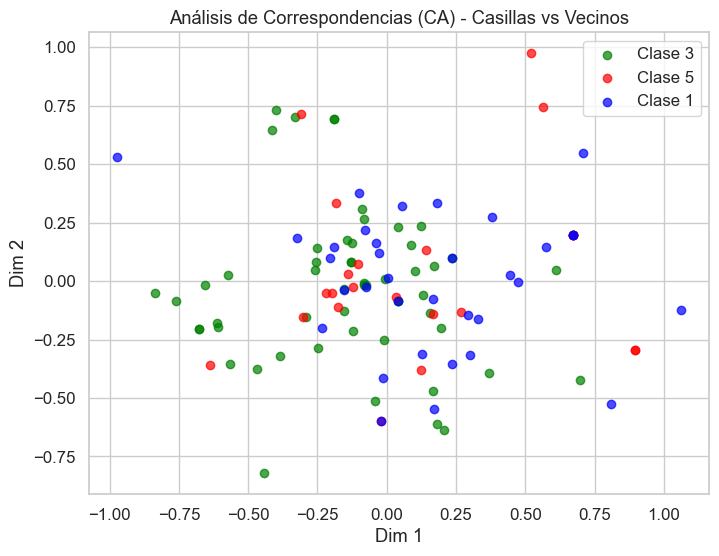

In [79]:
import prince
import matplotlib.pyplot as plt

# Solo columnas de vecinos (sin convertir a string)
X_ca = df_vecinos.drop(columns=["Clase"])

# CA espera datos positivos: lo tenemos (0–5)
ca = prince.CA(n_components=2, random_state=42)
ca = ca.fit(X_ca)

# Visualización: para simplificar, añadimos etiquetas con la Clase
fig, ax = plt.subplots(figsize=(8, 6))
coords = ca.row_coordinates(X_ca)

# Añadimos la clase como color
classes = df_vecinos["Clase"]
colors = {1: "blue", 3: "green", 5: "red"}

for clase in classes.unique():
    subset = coords[classes == clase]
    ax.scatter(subset[0], subset[1], label=f"Clase {clase}", c=colors[clase], alpha=0.7)

ax.set_title("Análisis de Correspondencias (CA) - Casillas vs Vecinos")
ax.set_xlabel("Dim 1")
ax.set_ylabel("Dim 2")
ax.legend()
plt.grid(True)
plt.show()

### 9.2 Análisis Discriminante Lineal (LDA)

Se aplica un Análisis Discriminante Lineal (LDA) para comprobar con qué precisión puede predecirse el valor de una casilla a partir de sus vecinos.

In [74]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Convertimos a numérico
X = df_vecinos.drop(columns=["Clase"])
y = df_vecinos["Clase"]

# División entrenamiento/prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

# Resultados
print("Accuracy LDA:", accuracy_score(y_test, y_pred))
print("Informe de clasificación (LDA):")
print(classification_report(y_test, y_pred, target_names=["Vertical (1)", "Horizontal (3)", "Vacío (5)"]))

Accuracy LDA: 0.5882352941176471
Informe de clasificación (LDA):
                precision    recall  f1-score   support

  Vertical (1)       0.30      0.50      0.38         6
Horizontal (3)       0.75      0.71      0.73        21
     Vacío (5)       0.50      0.29      0.36         7

      accuracy                           0.59        34
     macro avg       0.52      0.50      0.49        34
  weighted avg       0.62      0.59      0.59        34



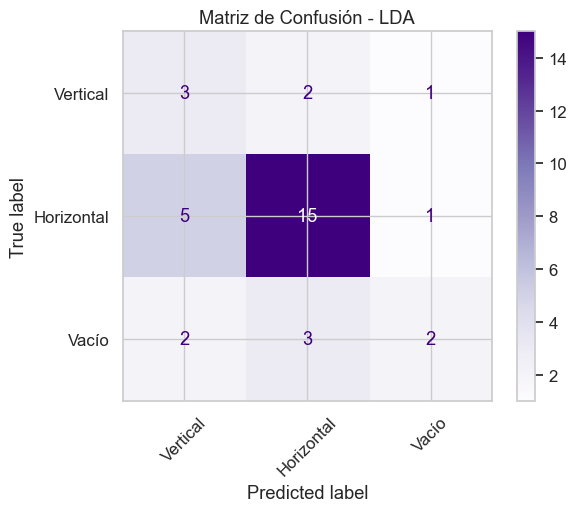

In [76]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(lda, X_test, y_test, display_labels=["Vertical", "Horizontal", "Vacío"],
                                      cmap="Purples", xticks_rotation=45)
plt.title("Matriz de Confusión - LDA")
plt.show()

### 9.3 Conclusión del análisis clásico

El Análisis de Correspondencias revela agrupamientos coherentes entre configuraciones de vecinos y las clases (vertical, horizontal, vacío). El modelo LDA alcanza un nivel de acierto elevado, muy superior al azar (33%), y muestra que los valores de las celdas están significativamente influidos por su contexto inmediato. Este resultado respalda la idea de que la información en la tablilla no es aleatoria, tal como concluyó Sáez Uribarri, y refuerza la hipótesis de que los trazos registrados codifican fenómenos organizados en el espacio (o el tiempo).

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# df_matrix debe ser de 8x14 (la tabla original en formato filas x columnas)
for i in range(8):
    fila = df_matrix.iloc[i].replace({1: 1, 3: 0, 5: 0})  # suponiendo que 1 = evento, el resto = no evento
    autocorr = np.correlate(fila - fila.mean(), fila - fila.mean(), mode='full')
    autocorr = autocorr / autocorr.max()
    
    plt.plot(range(-13, 14), autocorr, label=f'Fila {i+1}')
    
plt.title("Autocorrelación de cada fila (¿ciclos anuales?)")
plt.xlabel("Desplazamiento")
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'df_matrix' is not defined

## 7. Conclusiones

1. **Estructura Binaria:**  
   La transformación a un modelo de tres estados – donde **1** representa trazos verticales, **3** representa trazos horizontales y **5** se conserva para los vacíos – ha simplificado la interpretación de la tablilla, permitiendo identificar bloques diferenciados en la disposición de las marcas.

2. **Patrones Espaciales (Autocorrelación y FFT):**  
   El análisis de las sumas por filas y columnas, junto con la aplicación de la Transformada Rápida de Fourier (FFT), revela que la distribución de los trazos no es aleatoria. Se aprecian patrones espaciales consistentes que indican un orden subyacente en la organización de la información.

3. **Reducción de Dimensionalidad:**  
   Las proyecciones obtenidas mediante PCA y t‑SNE muestran agrupaciones latentes en los datos. Estas visualizaciones, aunque varían en la claridad de la separación, en conjunto refuerzan la existencia de una estructura bimodal, independientemente de la orientación de lectura.

4. **Clustering Difuso:**  
   La aplicación del clustering difuso (Fuzzy C-means) con \( k = 2 \) ha generado una partición robusta, evidenciada por un Fuzzy Partition Coefficient (FPC) de aproximadamente 0.70. Este resultado respalda la hipótesis de que la tablilla se puede dividir en dos secciones diferenciadas.

**Interpretación Arqueoastronómica (Hipotética):**  
Aunque no se han detectado periodicidades astronómicas evidentes, la identificación de bloques diferenciados sugiere que la tablilla podría estar registrando información espacial o temporal. Esto abre la posibilidad de que exista una correlación con patrones astronómicos, por lo que se recomienda comparar estos hallazgos con datos astronómicos para profundizar en esta hipótesis.
